# CS576 Assignment #2: Image Classification using Convolutional Neural Networks (CNNs) 
---
Primary TA : Whie Jung

TA's E-mail : whieya@kaist.ac.kr, wogns98@kaist.ac.kr 

QnA Channel: Same Slack workspace but with *assignment2* channel (https://join.slack.com/t/kaistcs576/shared_invite/zt-o3gqak0y-yj3NCb_SQFxVkqO0U6PWYw)

---

## Instruction
- In this assignment, we will classify the images in CIFAR10 dataset into 10 categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) using Convolutional Neural Networks.  

- For this, you first need to implement necessary network components (e.g. residual blocks) using nn.Module class. Then, you need to implement data pipeline. Finally, you need to implement an entire training/test pipeline.  

- In each part, you will be given a starter code for the implementation. Please read the attached illustrations and instructions carefully to implement the codes.  

- As you follow the given steps, fill in the section marked ***Px.x*** (e.g. P1.1, P1.2, etc) with the appropriate code.

- DO NOT modify any of the skeleton codes except the area where we allow you to change. Please write your codes only in the designated area.

## Submission guidelines
- Your code and report will be all in Colab. 
- Go to the [link](https://drive.google.com/drive/folders/1XQT-Mk31_jc3KqXYX1FyMIcmtLutrKzj?usp=sharing), find `assignment2.ipynb` and `dataset.tar.gz`, save them into your own google drive by clicking `make a copy(사본만들기)`. Find the copies in your drive, change their name to `assignment2.ipynb` and `dataset.tar.gz`, respectively, if their names were changed to e.g. `Copy of assignment2.ipyb` or `assignment2.ipynb의 사본`. Also, keep them in a single directory.
- <font color="red"> You will get the full credit **only if** you complete the code **and** write a discussion of the results in the discussion section at the bottom of this page. </font>
- We should be able to reproduce your results using your code. Please double-check if your code runs without error and reproduces your results. Submissions failed to run or reproduce the results will get a substantial penalty. 

## Deliverables
- Download your Colab notebook and submit it in a format as : **[StudentID].ipynb**.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions. 

## Due date
- **23:59:59 May 4th.**
- Late submission is allowed until 23:59:59 May 6th.
- Late submission will be applied 20% penalty.


## Questions
- We will use the same SLACK channel (https://join.slack.com/t/kaistcs576/shared_invite/zt-o3gqak0y-yj3NCb_SQFxVkqO0U6PWYw) as a main communication channel. When you post questions, please make it public so that all students can share the information. 


## Changelog
- 04/18 03:02 : Added the cells defining result_dir and log_dir above the cell executing the tensorboard. Also added L12~L17 in the function train().
- 04/18 14:01 : Removed remounting (the part including drive.mount('/content/drive'))

---

---


# Prerequisite: change the runtime type to **GPU**.

![test](https://docs.google.com/uc?export=download&id=1Jugrjl86L9EY1ePTjH8OVMFq7gmZsoz_)

---
# Prerequisite: mount your gdrive.

In [ ]:
# mount drive https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab
import os
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


---
# Prerequisite: setup the `root` directory properly.

In [ ]:
# Specify the directory path where `assignemnt2.ipynb` and `dataset.tar.gz` exist.
# For example, if you saved `assignment2.ipynb` and `dataset.tar.gz` in `/gdrive/My Drive/cs576/assignment2` directory,
# then set root = '/gdrive/My Drive/cs576/assignment2'
root = '/gdrive/My Drive/Homework2'

# Extract copied `dataset.tar.gz`.
!tar -xzf '/gdrive/My Drive/'{root.replace('/gdrive/My Drive/', '').strip('/')}'/dataset.tar.gz'

---
# Import libraries

In [ ]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

-----

# Network Modules

In this section, you need to implement three modularized layer (or network) classes as follows:

(1) plain residual block (ResBlockPlain)  
(2) residual block with bottleneck (ResBlockBottleneck)  
(3) an entire network module (MyNetwork)  


In each cell, there is a starter code as well as a schematic illustration and instruction for implementing that module class. Specifically, the schematic illustrations are to show you the computational graphs of modules, which give you high-level views on how the modules should be constructed and work. (E.g. which nn.Module to use, or input/output shape of each layer written in italics). Therefore, please read the illustrations and instructions carefully to complete the codes.

Below is an example.

### Example: ConvLayer Module [(Illustration)](https://docs.google.com/drawings/d/1_aPhPSPgh5-5FEfI_jnfp8r6-wNjY_QYXBT3zzjkHk0/edit?usp=sharing)

In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, activation_type='relu', use_bn=False):
        super(ConvLayer, self).__init__()
        """Initialize a basic convolutional layer module components.

        Illustration: https://docs.google.com/drawings/d/1_aPhPSPgh5-5FEfI_jnfp8r6-wNjY_QYXBT3zzjkHk0/edit?usp=sharing

        Instructions:
            1. Implement an algorithm that initializes necessary components as illustrated in the above link. 
            2. Initialized network components will be referred in `forward` method 
               for constructing the dynamic computational graph.

        Args:
            1. in_channels (int): Number of channels in the input. 
            2. out_channels (int): Number of channels produced by the convolution.
            3. activation_type (string, optional): Type of non-linear activation function to use. (default: 'relu') 
            4. use_bn (bool, optional): Whether to use batch normalization. (default: False)
        """
        ##########################
        ## Write your code here ##
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity() 

        if activation_type == 'relu':
            self.act = nn.ReLU(True)
        elif activation_type == 'lrelu':
            self.act = nn.LeakyReLU(0.2, True)
        elif activation_type == 'sigmoid':
            self.act = nn.Sigmoid()
        elif activation_type == 'tanh':
            self.act = nn.Tanh()
        elif activation_type == 'none':
            self.act = nn.Identity() 
        else:
            raise ValueError('Unknown activation_type !')
        ##########################

    def forward(self, x):
        """Feed-forward the data `x` through the module.

        Instructions:
            1. Construct the feed-forward computational graph as illustrated in the link 
               using the initialized components in the __init__ method.

        Args:
            1. x (torch.FloatTensor): A tensor of shape (B, in_channels, H, W).

        Returns:
            1. output (torch.FloatTensor): An output tensor of shape (B, out_channels, H, W). 

        """
        ###########################
        ## Write your code here ##
        output = self.conv(x)
        output = self.bn(output)
        output = self.act(output)
        ###########################
        return output

In [ ]:
# Check and test your ConvLayer here
# You may modify this cell for debugging

in_channels = 8
out_channels = 16
activation_type = 'relu'
use_bn = True

convlayer_test = ConvLayer(in_channels, out_channels, activation_type, use_bn)
print(convlayer_test)

B, C, H, W = 1, in_channels, 32, 32
x_test = torch.randn(1, C, H, W)
print('input shape: ', x_test.shape, '| dtype: ', x_test.dtype)

output = convlayer_test(x_test)
print('output shape: ', output.shape, '| dtype: ', output.dtype)


ConvLayer(
  (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
)
input shape:  torch.Size([1, 8, 32, 32]) | dtype:  torch.float32
output shape:  torch.Size([1, 16, 32, 32]) | dtype:  torch.float32


### 1. Implement ResBlockPlain [(Illustration)](https://docs.google.com/drawings/d/1N0vi9S-RwDAjyJoC9eCVWwHnlKXfSlflf2xWTGEFRFQ/edit?usp=sharing) (10pt)

In [ ]:
class ResBlockPlain(nn.Module):
    def __init__(self, in_channels, use_bn=False):
        super(ResBlockPlain, self).__init__()
        """Initialize a residual block module components.

        Illustration: https://docs.google.com/drawings/d/1N0vi9S-RwDAjyJoC9eCVWwHnlKXfSlflf2xWTGEFRFQ/edit?usp=sharing

        Instructions:
            1. Implement an algorithm that initializes necessary components as illustrated in the above link. 
            2. Initialized network components will be referred in `forward` method 
               for constructing the dynamic computational graph.

        Args:
            1. in_channels (int): Number of channels in the input.
            2. use_bn (bool, optional): Whether to use batch normalization. (default: False)
        """
        #################################
        ## P1.1. Write your code here ##
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels) if use_bn else nn.Identity() 
        self.act1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3,stride=1,padding=1)
        self.act2 = nn.ReLU(True)
        #################################

    def forward(self, x):
        """Feed-forward the data `x` through the network.

        Instructions:
            1. Construct the feed-forward computational graph as illustrated in the link 
               using the initialized components in __init__ method.

        Args:
            1. x (torch.FloatTensor): An tensor of shape (B, in_channels, H, W).

        Returns:
            1. output (torch.FloatTensor): An output tensor of shape (B, out_channels, H, W). 
        """
        ################################
        ## P1.2. Write your code here ##
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.act1(output)
        output = self.conv2(output)
        output = output + x 
        output = self.act2(output)
        ################################
        return output 

In [ ]:
# Check and test your ResBlockPlain here
# You may modify this cell for debugging

in_channels = 16
use_bn = True

resblockplain_test = ResBlockPlain(in_channels, use_bn)
print(resblockplain_test)

B, C, H, W = 1, in_channels, 32, 32
x_test = torch.randn(1, C, H, W)
print('input shape: ', x_test.shape, '| dtype: ', x_test.dtype)

output = resblockplain_test(x_test)
print('output shape: ', output.shape, '| dtype: ', output.dtype)

ResBlockPlain(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU(inplace=True)
)
input shape:  torch.Size([1, 16, 32, 32]) | dtype:  torch.float32
output shape:  torch.Size([1, 16, 32, 32]) | dtype:  torch.float32


### 2. Implement ResBlockBottleneck [(Illustration)](https://docs.google.com/drawings/d/1cpqMoRKtVvLy6Zwt7HziEm3DyGsbNF6jYCTCCbm5WZY/edit?usp=sharing) (10pt)

In [ ]:
class ResBlockBottleneck(nn.Module):
    def __init__(self, in_channels, hidden_channels, use_bn=False):
        super(ResBlockBottleneck, self).__init__()
        """Initialize a residual block module components.

        Illustration: https://docs.google.com/drawings/d/1cpqMoRKtVvLy6Zwt7HziEm3DyGsbNF6jYCTCCbm5WZY/edit?usp=sharing

        Instructions:
            1. Implement an algorithm that initializes necessary components as illustrated in the above link. 
            2. Initialized network components will be referred in `forward` method 
               for constructing the dynamic computational graph.

        Args:
            1. in_channels (int): Number of channels in the input. 
            2. hidden_channels (int): Number of hidden channels produced by the first ConvLayer module.
            3. use_bn (bool, optional): Whether to use batch normalization. (default: False)
        """
        #################################
        ## P2.1. Write your code here ##
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(hidden_channels) if use_bn else nn.Identity() 
        self.act1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels) if use_bn else nn.Identity() 
        self.act2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.act3 = nn.ReLU(True)
        #################################

    def forward(self, x):
        """Feed-forward the data `x` through the network.

        Instructions:
            1. Construct the feed-forward computational graph as illustrated in the link 
               using the initialized components in __init__ method.

        Args:
            1. x (torch.FloatTensor): An tensor of shape (B, in_channels, H, W).

        Returns:
            1. output (torch.FloatTensor): An output tensor of shape (B, out_channels, H, W). 
        """
        ################################
        ## P2.2. Write your code here ##
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.act1(output)
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.act2(output)
        output = self.conv3(output)
        output = output + x 
        output = self.act3(output)

        ################################
        return output 

In [ ]:
# Check and test your ResBlockBottleneck here
# You may modify this cell for debugging

in_channels = 16
hidden_channels = 8
use_bn = True

resblockbottleneck_test = ResBlockBottleneck(in_channels, hidden_channels, use_bn)
print(resblockbottleneck_test)

B, C, H, W = 1, in_channels, 32, 32
x_test = torch.randn(1, C, H, W)
print('input shape: ', x_test.shape, '| dtype: ', x_test.dtype)

output = resblockbottleneck_test(x_test)
print('output shape: ', output.shape, '| dtype: ', output.dtype)

ResBlockBottleneck(
  (conv1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (conv3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  (act3): ReLU(inplace=True)
)
input shape:  torch.Size([1, 16, 32, 32]) | dtype:  torch.float32
output shape:  torch.Size([1, 16, 32, 32]) | dtype:  torch.float32


### 3. Implement MyNetwork [(Illustration)](https://docs.google.com/drawings/d/1dN2RLaCpK5W61A9s2WhdOfZDuDBn6JtIJmWmIAIMgtg/edit?usp=sharing) (20pt)

In [ ]:
class MyNetwork(nn.Module):
    def __init__(self, nf, resblock_type='plain', num_resblocks=[1, 1, 1], use_bn=False):
        super(MyNetwork, self).__init__()
        """Initialize an entire network module components.

        Illustration: https://docs.google.com/drawings/d/1dN2RLaCpK5W61A9s2WhdOfZDuDBn6JtIJmWmIAIMgtg/edit?usp=sharing

        Instructions:
            1. Implement an algorithm that initializes necessary components as illustrated in the above link. 
            2. Initialized network components will be referred in `forward` method 
               for constructing the dynamic computational graph.

        Args:
            1. nf (int): Number of output channels for the first nn.Conv2d Module. An abbreviation for num_filter.
            2. resblock_type (str, optional): Type of ResBlocks to use. ('plain' | 'bottleneck'. default: 'plain')
            3. num_resblocks (list or tuple, optional): A list or tuple of length 3. 
               Each item at i-th index indicates the number of residual blocks at i-th Residual Layer.  
               (default: [1, 1, 1])
            4. use_bn (bool, optional): Whether to use batch normalization. (default: False)
        """
        ################################
        ## P3.1. Write your code here ##
        self.conv1 = nn.Conv2d(3,nf, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU(True)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        first_res = []
        if resblock_type == 'plain':
          for i in range(num_resblocks[0]):
            first_res.append(ResBlockPlain(in_channels=nf, use_bn=use_bn))
        elif resblock_type == 'bottleneck':
          for i in range(num_resblocks[0]):
            first_res.append(ResBlockBottleneck(in_channels=nf, hidden_channels=nf//2, use_bn=use_bn))
        self.first_residual = nn.Sequential(*first_res)

        self.conv2 = nn.Conv2d(nf, 2*nf, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU(True)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        second_res = []
        if resblock_type == 'plain':
          for i in range(num_resblocks[1]):
            second_res.append(ResBlockPlain(in_channels=2*nf, use_bn = use_bn))
        elif resblock_type == 'bottleneck':
          for i in range(num_resblocks[1]):
            second_res.append(ResBlockBottleneck(in_channels=2*nf, hidden_channels=nf, use_bn= use_bn))
        self.second_residual = nn.Sequential(*second_res)

        self.conv3 = nn.Conv2d(2*nf, 4*nf, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU(True)
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        third_res = []
        if resblock_type == 'plain':
          for i in range(num_resblocks[2]):
            third_res.append(ResBlockPlain(in_channels= 4*nf, use_bn=use_bn))
        elif resblock_type == 'bottleneck':
          for i in range(num_resblocks[2]):
            third_res.append(ResBlockBottleneck(in_channels= 4*nf, hidden_channels= 2*nf, use_bn=use_bn))
        self.third_residual = nn.Sequential(*third_res)

        self.conv4 = nn.Conv2d(4*nf, 8*nf, kernel_size= 3, stride= 1, padding= 1)
        self.act4 = nn.ReLU(True)
        self.avgpool4 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(nf*8*2*2, 256)
        self.act5 = nn.ReLU(True)
        self.linear2 = nn.Linear(256, 10)
        ################################

        # When all components are initialized, perform weight initialization on weights and biases.
        self.apply(self.init_params)

    def forward(self, x):
        """Feed-forward the data `x` through the network.

        Instructions:
            1. Construct the feed-forward computational graph as illustrated in the link 
               using the initialized network components in __init__ method.
        Args:
            1. x (torch.FloatTensor): An image tensor of shape (B, 3, 32, 32).

        Returns:
            1. output (torch.FloatTensor): An output tensor of shape (B, 10). 
        """
        ################################
        ## P3.2. Write your code here ##
        output = self.conv1(x)
        output = self.act1(output)
        output = self.avgpool1(output)
        output = self.first_residual(output)
        output = self.conv2(output)
        output = self.act2(output)
        output = self.avgpool2(output)
        output = self.second_residual(output)
        output = self.conv3(output)
        output = self.act3(output)
        output = self.avgpool3(output)
        output = self.third_residual(output)

        output = self.conv4(output)
        output = self.act4(output)
        output = self.avgpool4(output)

        output = self.flatten(output)
        output = self.linear1(output)
        output = self.act5(output)
        output = self.linear2(output)
        ################################
        return output

    def init_params(self, m):
        """Perform weight initialization on model parameters.

        Instructions:
            1. For nn.Conv2d and nn.Linear modules, 
               initialize their weights using Kaiming He Normal initialization,
               and initialize their biases with zeros.

            2. For nn.BatchNorm2d modules,
               initialize their weights with ones,
               and initizlie their biases with zeros.

            3. Otherwise, do not perform initialization.

            4. No need to return anything in this method.

            5. Hint: refer to the page 44 of the 'lecture note: tutorial on Pytorch [04/12]'

        Args:
            1. m (nn.Module) 
        """
        ################################
        ## P3.3. Write your code here ##
        if isinstance(m, (nn.Conv2d)) or isinstance(m, (nn.Linear)):
          nn.init.kaiming_uniform_(m.weight)
          m.bias.data.zero_()
        if isinstance(m, (nn.BatchNorm2d)):
          m.weight.data.fill_(1)
          m.bias.data.zero_()
        ################################

    def compute_loss(self, logit, y):
        """Compute cross entropy loss.

        Hint: 
            If logit = torch.tensor([[-0.1, 0.2, -0.3, 0.4, -0.5, 0.6, -0.7, 0.8, -0.9, 1.0]]).float(),
            and y = torch.ones(1).long(), then loss value equals to 2.3364xxxx

        Args:
            1. logit (torch.FloatTensor): A tensor of shape (B, 10). 
            2. y (torch.LongTensor): A tensor of shape (B).

        Returns:
            1. loss (torch.FloatTensor): Computed cross entropy loss.
        """
        ################################
        ## P3.4. Write your code here ##
        compute_loss = nn.CrossEntropyLoss()
        loss = compute_loss(logit, y)
        ################################
        return loss

In [ ]:
# Check and test your Network here
# You may modify this cell for debugging

num_filters = 16
num_resblocks = [1, 2, 3]
resblock_type = 'bottleneck'
use_bn = True

mynetwork_test = MyNetwork(num_filters, resblock_type, num_resblocks, use_bn)
print(mynetwork_test)

B, C, H, W = 1, 3, 32, 32
x_test = torch.randn(1, C, H, W)
y_test = torch.ones(1).long()
print('input shape: ', x_test.shape, '| dtype: ', x_test.dtype)
print('label shape: ', y_test.shape, '| dtype: ', y_test.dtype)

logit = mynetwork_test(x_test)
print('logit shape: ', logit.shape, '| dtype: ', logit.dtype)

loss_test = mynetwork_test.compute_loss(logit, y_test)
print('computed loss:', loss_test.item())

MyNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU(inplace=True)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (first_residual): Sequential(
    (0): ResBlockBottleneck(
      (conv1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
      (act3): ReLU(inplace=True)
    )
  )
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU(inplace=True)
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (second_residual): Sequential(
    (0): ResBlockBottleneck(
      (conv1): Conv2d(32, 16, kerne

---

# Dataset and DataLoader

In this section, you need to implement data pipeline, as illustrated in **lecture note: Pytorch tutorial [4/12]**

Like Network section, you are provided with starter codes for the data pipeline.

Please refer to the instructions carefully to complete the codes.

### 4-1. Implement CIFAR10 Dataset Class (15pt)

In [ ]:
class CIFAR10(Dataset):
    """Customized `CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Read the following descriptions on the dataset directory structure carefully to implement this `CIFAR10` class.

    In `dataset/cifar10` directory, you have `train` and `test` directories,
    each of which contains CIFAR10 images for the train and test, respectively.

    Also, there are 10 sub-directories (from `0` to `9`) in `train` and `test` directories, 
    where the name of each sub-directory is specified by CIFAR10 classes and 
    each sub-directory contains images for those classes. 

    For train data, there are 10*4,800=48,000 images in total (4,800 images for each class), 
    whereas test data consists of 10*1,200=12,000 images (1,200 images for each class). 

    For example,

    datset
        `-- cifar10
            |-- train
                |-- 0
                    |-- 00001.png
                    |-- ...
                    `-- 04800.png
                |-- ...
                `-- 9
                    |-- 00001.png
                    |-- ...
                    `-- 04800.png
            `-- test
                |-- 0
                    |-- 04801.png
                    |-- ...
                    `-- 06000.png
                |-- ...
                `-- 9
                    |-- 04801.png
                    |-- ...
                    `-- 06000.png

    """
    def __init__(self, root, train=True, transform=None):
        super(CIFAR10, self).__init__()
        """
        Instructions: 
            1. Assume that `root` equals to `dataset/cifar10`.

            2. If `train` is True, then parse all paths of train images, and keep them in the list `self.paths`. 
               E.g.) self.paths = ['dataset/cifar10/train/0/00001.png', ..., 'dataset/cifar10/train/9/4800.png']
               Also, the length of `self.paths` list should be 48,000.
                    
            3. If `train` is False, then parse all paths of test images, and keep them in the list `self.paths`. 
               E.g.) self.paths = ['dataset/cifar10/test/0/04801.png', ..., 'dataset/cifar10/test/9/06000.png']
               Also, the length of `self.paths` list should be 12,000.

        Args:
            root (string): Root directory of dataset where directory ``cifar10`` exists.
            train (bool, optional): If True, creates dataset from training set, otherwise
                creates from test set. (default: True)
            transform (callable, optional): A function/transform that takes in an PIL image
                and returns a transformed version. E.g, ``transforms.RandomCrop`` (default: None)
        """
        self.transform = transform 

        ################################
        ## P4.1. Write your code here ##
        import os
        collect_path = []
        dir_path = root + '/train' if train is True else root + '/test'
        list_class = os.listdir(dir_path) # ['0', '1','2', ...'9']
        for class_name in list_class: 
          class_dir = dir_path + '/' + class_name 
          img_names_list = os.listdir(class_dir)
          for img_name in img_names_list: 
            img_path = class_dir + '/' + img_name 
            collect_path.append(img_path)
        self.paths = collect_path
        ################################

        assert isinstance(self.paths, (list,)), 'Wrong type. self.paths should be list.'
        if train is True:
            assert len(self.paths) == 48000, 'There are 48,000 train images, but you have gathered %d image paths' % len(self.paths)
        else:
            assert len(self.paths) == 12000, 'There are 12,000 test images, but you have gathered %d image paths' % len(self.paths)

    def __getitem__(self, idx):
        """
        Instructions:
            1. Given a path of an image, which is grabbed by self.paths[idx], infer the class label of the image.
            2. Convert the inferred class label into torch.LongTensor with shape (), and keep it in `label` variable.` 

        Args:
            idx (int): Index of self.paths

        Returns:
            image (torch.FloatTensor): An image tensor of shape (3, 32, 32).
            label (torch.LongTensor): A label tensor of shape ().
        """

        path = self.paths[idx] 
        # P4.2. Infer class label from `path`,
        # write your code here.
        # ['dataset/cifar10/train/0/00001.png', ..., 'dataset/cifar10/train/9/4800.png']
        label_int = int(path.split('/')[3])

        # P4.3. Convert it to torch.LongTensor with shape ().
        # label = write_your_code_here (one-liner).
        label = torch.tensor(label_int).long()

        image = Image.open(path)
        if self.transform is not None:
            image = self.transform(image) 

        return image, label

    def __len__(self):
        return len(self.paths)

In [ ]:
# Check and test your CIFAR10 Dataset class here.
# You may modify this cell for debugging

data_dir = 'dataset/cifar10'
train = True
transform = transforms.ToTensor()

dset = CIFAR10(data_dir, train, transform)
print('num data:', len(dset))

x_test, y_test = dset[0]
print('image shape:', x_test.shape, '| type:', x_test.dtype)
print('label shape:', y_test.shape, '| type:', y_test.dtype)

num data: 48000
image shape: torch.Size([3, 32, 32]) | type: torch.float32
label shape: torch.Size([]) | type: torch.int64


### 4-2. Implement DataLoader (5pt)

In [ ]:
def get_dataloader(args):
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])
    train_dataset = CIFAR10(args.dataroot, train=True, transform=transform)
    test_dataset = CIFAR10(args.dataroot, train=False, transform=transform)

    # P4.4. Use `DataLoader` module for mini-batching train and test datasets.
    # train_dataloader = DataLoader(WRITE_YOUR_CODE_HERE, batch_size=args.batch_size, shuffle=True, drop_last=True)
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
    # test_dataloader = DataLoader(WRITE_YOUR_CODE_HERE, batch_size=args.batch_size, shuffle=False, drop_last=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False)

    return train_dataloader, test_dataloader

---

# 5. Train/Test Pipeline (40pt)

In this section, you need to implement the entire train and test loop in the pipeline.

Specifically, you need to do the followings:
1. feed inputs into the network, get outputs, and then compute classification loss. 
2. backward the computed loss and update network weights (only in the training loop).
3. save tensorboard logs frequently.
4. save checkpoint weights frequently.

Please refer to the **lecture note: Pytorch Tutorial [4/12]**. There are a lot of hints for implementing this pipeline !

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'main'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 32                # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'bottleneck'    # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 2, 3]       # number of residual blocks in each Residual Layer.
args.use_bn = False                  # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 64                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

In [ ]:
# Added 04/18
# Basic settings
device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

result_dir = Path(root) / 'results' /args.name
ckpt_dir = result_dir / args.ckpt_dir
ckpt_dir.mkdir(parents=True, exist_ok=True)
log_dir = result_dir / args.log_dir
log_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Setup tensorboard.
if args.tensorboard:
    from torch.utils.tensorboard import SummaryWriter 
    writer = SummaryWriter(log_dir)
    %load_ext tensorboard
    %tensorboard --logdir '/gdrive/My Drive/'{str(log_dir).replace('/gdrive/My Drive/', '')}
else:
    writer = None

In [ ]:
def train(args):

    # Basic settings
    device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

    result_dir = Path(root) / 'results' /args.name
    ckpt_dir = result_dir / args.ckpt_dir
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    log_dir = result_dir / args.log_dir
    log_dir.mkdir(parents=True, exist_ok=True)

    # Added 04/18
    if args.tensorboard:
        from torch.utils.tensorboard import SummaryWriter 
        writer = SummaryWriter(log_dir)
    else:
        writer = None
        
    epoch = 0
    global_step = 0
    best_accuracy = 0.

    # Define your model and optimizer
    # Complete ResBlockPlain, ResBlockBottleneck, and MyNetwork modules to proceed further.
    net = MyNetwork(args.num_filters, args.resblock_type, args.num_resblocks, args.use_bn).to(device)
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    # Resume the training 
    if args.resume:
        ckpt_path = ckpt_dir / ('%s.pt' % args.ckpt_reload)

        try:
            checkpoint = torch.load(ckpt_path)
            net.load_state_dict(checkpoint['net'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            epoch = checkpoint['epoch'] + 1
            best_accuracy = checkpoint['best_accuracy']
            print(f'>> Resume training from epoch {epoch+1}')

        except Exception as e:
            print(e)

    # Get train/test data loaders  
    # Complete CIFAR10 dataset class and get_dataloader method to proceed further.
    train_dataloader, test_dataloader = get_dataloader(args)

    # Start training
    # Save the starting time
    start_time = time.time()

    for epoch in range(epoch, args.epoch):
        # start time
        _start_time = time.time() 

        # Here starts the train loop.
        net.train()
        for x, y in train_dataloader:
            global_step += 1

            # P5.1. Send `x` and `y` to either cpu or gpu using `device` variable. 
            # x = write your code here (one-liner). 
            # y = write your code here (one-liner).
            x = x.to('cuda')
            y = y.to('cuda')
            
            # P5.2. Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
            # logit = write your code here (one-liner).
            logit = net(x)

            # P5.3. Compute loss using `logit` and `y`, and keep it in a variable called `loss` 
            # loss =  write your code here (one-liner).
            loss = net.compute_loss(logit, y)
            accuracy = (logit.argmax(dim=1)==y).float().mean()

            # P5.4. flush out the previously computed gradient 
            # write your code here (one-liner).
            optimizer.zero_grad()

            # P5.5. backward the computed loss. 
            # write your code here (one-liner).
            loss.backward()

            # P5.6. update the network weights. 
            # write your code here (one-liner).
            optimizer.step()

            if global_step % args.log_iter == 0 and writer is not None:
                # P5.7. Log `loss` with a tag name 'train_loss' using `writer`. Use `global_step` as a timestamp for the log. 
                # writer.writer_your_code_here (one-liner).
                writer.add_scalar('train_loss', loss, global_step)

                # P5.8. Log `accuracy` with a tag name 'train_accuracy' using `writer`. Use `global_step` as a timestamp for the log. 
                # writer.writer_your_code_here (one-liner).
                writer.add_scalar('train_accuracy', accuracy, global_step)

        # print train loss, acc, time spent 
        t = time.time()-_start_time
        print(f'Epoch {epoch}/{args.epoch} || train loss={loss:.4f} train acc={accuracy*100:.3f}% time={t:.3f} secs')

        # start time for test
        _start_time = time.time() 

        # Here starts the test loop.
        net.eval()
        with torch.no_grad():
            test_loss = 0.
            test_accuracy = 0.
            test_num_data = 0.
            for x, y in test_dataloader:
                # P5.9. Send `x` and `y` to either cpu or gpu using `device` variable.
                # x = write your code here (one-liner).
                # y = write your code here (one-liner).
                x = x.to('cuda')
                y = y.to('cuda')

                # P5.10. Feed `x` into the network, get an output, and keep it in a variable called `logit`.
                # logit = write your code here (one-liner). 
                logit = net(x)

                # P5.11. Compute loss using `logit` and `y`, and keep it in a variable called `loss`
                # loss = write your code yere (one-liner). 
                loss = net.compute_loss(logit, y)
                accuracy = (logit.argmax(dim=1) == y).float().mean()

                test_loss += loss.item()*x.shape[0]
                test_accuracy += accuracy.item()*x.shape[0]
                test_num_data += x.shape[0]

            test_loss /= test_num_data
            test_accuracy /= test_num_data

            if writer is not None: 
                # P5.12. Log `test_loss` with a tag name 'test_loss' using `writer`. Use `global_step` as a timestamp for the log.
                # writer.write_your_code_here (one-liner).
                writer.add_scalar('test_loss', test_loss, global_step)
                # P5.13. Log `test_accuracy` with a tag name 'test_accuracy' using `writer`. Use `global_step` as a timestamp for the log.
                # writer.write_your_code_here (one-liner).
                writer.add_scalar('test_accuracy', test_accuracy, global_step)
                writer.flush()

            # P5.14. Whenever `test_accuracy` is greater than `best_accuracy`, save network weights with the filename 'best.pt' in the directory specified by `ckpt_dir`.
            #     Here, just save the network weights (i.e, you don't need to save optimizer)
            #     Also, don't forget to update the `best_accuracy` properly.
            # write your code here. 
            if test_accuracy > best_accuracy: 
              best_accuracy = test_accuracy 
              weight_save_dir = str(ckpt_dir) + '/best.pt'
              torch.save(net.state_dict(), weight_save_dir)

        # P5.15. Save the checkpoint in the directory specified by `ckpt_dir` directory. 
        #    Note that the checkpoint must include network weights, optmizer states, current epoch, best acuuracy so far. 
        #    To see how those parameters are loaded, see the above cell that loads the checkpoint and resumes the training. 
        #    Hint) Write something like, torch.save(dict(epoch=, net=, optimizer=, best_accuracy=), checkpoint_filename)
        #    Also, use `epoch` to specify the timestamp in the checkpoint filename.
        #    E.g) if `epoch=10`, the filename can be `10.pt`
        # write your code here (one-liner).
        ckpt_filename_save = str(epoch) + '.pt'
        cpkt_save_path = str(ckpt_dir) + '/' + ckpt_filename_save
        torch.save({
            'epoch': epoch,
            'net': net.state_dict(), 
            'optimizer': optimizer.state_dict(), 
            'best_accuracy': best_accuracy
        }, cpkt_save_path)

        # print test loss, acc, time spent
        t = time.time()-_start_time
        print(f'Epoch {epoch}/{args.epoch} || test loss={loss:.4f} test acc={test_accuracy*100:.3f}% time={t:.3f} secs')

    # Print final accuracy with total time spent for training
    total_t = time.time()-start_time 
    print(f'Final best accuracy : {best_accuracy*100:.3f}% total time={total_t:.3f} secs')

In [ ]:
# Training
train(args)

Epoch 0/50 || train loss=1.5855 train acc=43.750% time=28.960 secs
Epoch 0/50 || test loss=1.3585 test acc=43.350% time=5.482 secs
Epoch 1/50 || train loss=1.4045 train acc=56.250% time=28.631 secs
Epoch 1/50 || test loss=1.8458 test acc=48.825% time=5.129 secs
Epoch 2/50 || train loss=1.0207 train acc=65.625% time=28.011 secs
Epoch 2/50 || test loss=1.8217 test acc=53.042% time=5.256 secs
Epoch 3/50 || train loss=1.1629 train acc=54.688% time=28.018 secs
Epoch 3/50 || test loss=1.7044 test acc=54.567% time=5.236 secs
Epoch 4/50 || train loss=1.3285 train acc=54.688% time=28.424 secs
Epoch 4/50 || test loss=1.0818 test acc=55.367% time=5.199 secs
Epoch 5/50 || train loss=1.1010 train acc=60.938% time=28.260 secs
Epoch 5/50 || test loss=1.0587 test acc=55.375% time=5.127 secs
Epoch 6/50 || train loss=1.1935 train acc=56.250% time=28.386 secs
Epoch 6/50 || test loss=1.7061 test acc=56.458% time=5.315 secs
Epoch 7/50 || train loss=0.9996 train acc=60.938% time=28.396 secs
Epoch 7/50 || te

---
# 6. Discussions (50pt)

Train and test at least 3 models with different configurations (for example, test with `ResBlockPlain` block instead of `ResBlockBottleneck` or you may stack more layers, etc) and hyper-parameters and discuss the results. Simply reporting the results (e.g. classification accuracy) is not considered as a discussion. You should explain which components lead to differences and analyze the reason for those differences. 

For the experiments, you can change the configurations and hyper-parameters by modifying the values written in the cell defining configurations and hyper-parameters. **Also, don't forget to change `args.name` before you run the new experiment!** 

Then, run the experiments below and leave the logs including test accuracy as a proof that you actually conducted the experiments. Based on the experimental results, write your discussions. 

* Experiment #1 

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'Exp1'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 4                 # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'plain'         # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 1, 1]       # number of residual blocks in each Residual Layer.
args.use_bn = True                   # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 32                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

# Training
train(args)

Epoch 0/50 || train loss=1.7795 train acc=21.875% time=21.047 secs
Epoch 0/50 || test loss=1.4842 test acc=35.967% time=3.557 secs
Epoch 1/50 || train loss=1.8528 train acc=18.750% time=20.169 secs
Epoch 1/50 || test loss=1.3723 test acc=40.475% time=3.446 secs
Epoch 2/50 || train loss=1.7934 train acc=46.875% time=20.266 secs
Epoch 2/50 || test loss=1.4223 test acc=42.458% time=3.423 secs
Epoch 3/50 || train loss=1.3618 train acc=37.500% time=20.356 secs
Epoch 3/50 || test loss=1.3495 test acc=44.108% time=3.432 secs
Epoch 4/50 || train loss=1.6978 train acc=43.750% time=20.150 secs
Epoch 4/50 || test loss=1.0391 test acc=45.925% time=3.451 secs
Epoch 5/50 || train loss=1.3288 train acc=50.000% time=20.310 secs
Epoch 5/50 || test loss=1.0497 test acc=46.833% time=3.434 secs
Epoch 6/50 || train loss=1.3596 train acc=53.125% time=20.377 secs
Epoch 6/50 || test loss=1.0374 test acc=47.358% time=3.437 secs
Epoch 7/50 || train loss=1.3274 train acc=56.250% time=20.201 secs
Epoch 7/50 || te

* Experiment #2

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'Exp2'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 4                 # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'plain'         # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 1, 1]       # number of residual blocks in each Residual Layer.
args.use_bn = False                  # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 32                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

# Training
train(args)

Epoch 0/50 || train loss=1.8961 train acc=25.000% time=18.921 secs
Epoch 0/50 || test loss=1.6612 test acc=32.067% time=3.372 secs
Epoch 1/50 || train loss=1.6496 train acc=37.500% time=18.562 secs
Epoch 1/50 || test loss=1.4801 test acc=37.400% time=3.332 secs
Epoch 2/50 || train loss=1.6775 train acc=31.250% time=18.308 secs
Epoch 2/50 || test loss=1.2054 test acc=38.117% time=3.269 secs
Epoch 3/50 || train loss=1.5631 train acc=40.625% time=19.137 secs
Epoch 3/50 || test loss=1.4343 test acc=39.975% time=3.581 secs
Epoch 4/50 || train loss=1.5682 train acc=34.375% time=18.582 secs
Epoch 4/50 || test loss=1.1520 test acc=43.200% time=3.372 secs
Epoch 5/50 || train loss=1.6445 train acc=40.625% time=18.207 secs
Epoch 5/50 || test loss=1.4642 test acc=42.750% time=3.252 secs
Epoch 6/50 || train loss=1.7046 train acc=37.500% time=18.249 secs
Epoch 6/50 || test loss=1.4715 test acc=44.108% time=3.252 secs
Epoch 7/50 || train loss=1.2997 train acc=46.875% time=18.553 secs
Epoch 7/50 || te

* Experiment #3

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'Exp3'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 4                 # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'plain'         # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 1, 1]       # number of residual blocks in each Residual Layer.
args.use_bn = True                   # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 64                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

# Training
train(args)

Epoch 0/50 || train loss=1.9979 train acc=28.125% time=15.627 secs
Epoch 0/50 || test loss=1.4819 test acc=34.783% time=3.053 secs
Epoch 1/50 || train loss=1.7767 train acc=32.812% time=15.624 secs
Epoch 1/50 || test loss=1.1047 test acc=38.450% time=3.101 secs
Epoch 2/50 || train loss=1.7459 train acc=31.250% time=15.641 secs
Epoch 2/50 || test loss=1.4116 test acc=41.983% time=3.093 secs
Epoch 3/50 || train loss=1.6802 train acc=34.375% time=15.737 secs
Epoch 3/50 || test loss=1.2050 test acc=43.650% time=3.112 secs
Epoch 4/50 || train loss=1.4324 train acc=45.312% time=15.571 secs
Epoch 4/50 || test loss=1.1936 test acc=44.500% time=3.047 secs
Epoch 5/50 || train loss=1.5288 train acc=43.750% time=15.847 secs
Epoch 5/50 || test loss=1.2323 test acc=46.025% time=3.095 secs
Epoch 6/50 || train loss=1.4393 train acc=43.750% time=15.597 secs
Epoch 6/50 || test loss=1.2160 test acc=46.600% time=3.118 secs
Epoch 7/50 || train loss=1.4165 train acc=50.000% time=15.687 secs
Epoch 7/50 || te

Experiment #4

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'Exp4'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 32                 # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'plain'         # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 1, 1]       # number of residual blocks in each Residual Layer.
args.use_bn = True                   # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 64                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

# Training
train(args)

Epoch 0/50 || train loss=1.3464 train acc=48.438% time=15.428 secs
Epoch 0/50 || test loss=1.8650 test acc=51.000% time=3.491 secs
Epoch 1/50 || train loss=0.9512 train acc=65.625% time=15.499 secs
Epoch 1/50 || test loss=0.7871 test acc=58.508% time=3.445 secs
Epoch 2/50 || train loss=1.0089 train acc=67.188% time=15.742 secs
Epoch 2/50 || test loss=0.7222 test acc=59.758% time=3.504 secs
Epoch 3/50 || train loss=0.8468 train acc=65.625% time=15.548 secs
Epoch 3/50 || test loss=0.4612 test acc=61.992% time=3.481 secs
Epoch 4/50 || train loss=0.8491 train acc=67.188% time=15.559 secs
Epoch 4/50 || test loss=0.6696 test acc=62.992% time=3.465 secs
Epoch 5/50 || train loss=0.7309 train acc=71.875% time=15.542 secs
Epoch 5/50 || test loss=0.4335 test acc=65.708% time=3.435 secs
Epoch 6/50 || train loss=0.5605 train acc=78.125% time=15.575 secs
Epoch 6/50 || test loss=0.4531 test acc=66.733% time=3.499 secs
Epoch 7/50 || train loss=0.8720 train acc=62.500% time=15.575 secs
Epoch 7/50 || te

Experiment #5

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'Exp5'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 16                 # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'plain'         # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 1, 1]       # number of residual blocks in each Residual Layer.
args.use_bn = True                   # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 64                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

# Training
train(args)

Epoch 0/50 || train loss=1.3763 train acc=53.125% time=16.019 secs
Epoch 0/50 || test loss=1.2864 test acc=47.008% time=3.326 secs
Epoch 1/50 || train loss=1.3765 train acc=54.688% time=15.834 secs
Epoch 1/50 || test loss=1.7313 test acc=52.475% time=3.340 secs
Epoch 2/50 || train loss=1.2981 train acc=59.375% time=15.882 secs
Epoch 2/50 || test loss=1.1859 test acc=55.775% time=3.302 secs
Epoch 3/50 || train loss=1.2348 train acc=51.562% time=15.884 secs
Epoch 3/50 || test loss=0.9655 test acc=56.600% time=3.272 secs
Epoch 4/50 || train loss=1.2863 train acc=56.250% time=15.841 secs
Epoch 4/50 || test loss=0.9054 test acc=58.633% time=3.262 secs
Epoch 5/50 || train loss=0.9375 train acc=70.312% time=15.846 secs
Epoch 5/50 || test loss=0.7142 test acc=59.217% time=3.222 secs
Epoch 6/50 || train loss=1.1126 train acc=60.938% time=15.690 secs
Epoch 6/50 || test loss=0.7981 test acc=60.208% time=3.283 secs
Epoch 7/50 || train loss=0.9098 train acc=70.312% time=15.807 secs
Epoch 7/50 || te

Experiment #6

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'Exp6'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 16                # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'bottleneck'    # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 1, 1]       # number of residual blocks in each Residual Layer.
args.use_bn = True                   # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 64                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

# Training
train(args)

Epoch 0/50 || train loss=1.7814 train acc=34.375% time=17.163 secs
Epoch 0/50 || test loss=1.4430 test acc=42.992% time=3.214 secs
Epoch 1/50 || train loss=1.2789 train acc=56.250% time=17.146 secs
Epoch 1/50 || test loss=1.3032 test acc=47.742% time=3.474 secs
Epoch 2/50 || train loss=1.3010 train acc=56.250% time=17.916 secs
Epoch 2/50 || test loss=0.9518 test acc=49.617% time=3.167 secs
Epoch 3/50 || train loss=1.4878 train acc=50.000% time=16.785 secs
Epoch 3/50 || test loss=1.3261 test acc=51.292% time=3.155 secs
Epoch 4/50 || train loss=1.1973 train acc=60.938% time=16.943 secs
Epoch 4/50 || test loss=1.5650 test acc=51.942% time=3.229 secs
Epoch 5/50 || train loss=1.3611 train acc=43.750% time=16.905 secs
Epoch 5/50 || test loss=0.9521 test acc=54.092% time=3.212 secs
Epoch 6/50 || train loss=0.9997 train acc=68.750% time=16.965 secs
Epoch 6/50 || test loss=0.8138 test acc=53.867% time=3.177 secs
Epoch 7/50 || train loss=1.2332 train acc=56.250% time=17.040 secs
Epoch 7/50 || te

Experiment #7

In [ ]:
# Configurations & Hyper-parameters
# You may modify this cell for your experiments. 

from easydict import EasyDict as edict

args = edict()

# basic options 
args.name = 'Exp7'                   # experiment name.
args.resume = False                  # whether to resume. If you want to resume training, change this option.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_reload = '10'              # If you want to resume training, specify which epoch's checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 16                # number of output channels in the first nn.Conv2d module in MyNetwork.
args.resblock_type = 'plain'         # type of residual block. ('plain' | 'bottleneck').
args.num_resblocks = [1, 2, 3]       # number of residual blocks in each Residual Layer.
args.use_bn = True                   # whether or not to use batch normalization.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 64                 # number of mini-batch size.

# training options
args.lr = 0.0001                     # learning rate.
args.epoch = 50                      # training epoch.

# tensorboard options
args.tensorboard = True             # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

# Training
train(args)

Epoch 0/50 || train loss=1.2964 train acc=50.000% time=17.756 secs
Epoch 0/50 || test loss=1.7091 test acc=47.000% time=3.332 secs
Epoch 1/50 || train loss=1.3803 train acc=50.000% time=17.677 secs
Epoch 1/50 || test loss=1.1723 test acc=53.333% time=3.353 secs
Epoch 2/50 || train loss=1.3754 train acc=53.125% time=17.742 secs
Epoch 2/50 || test loss=1.1196 test acc=54.675% time=3.353 secs
Epoch 3/50 || train loss=1.2000 train acc=62.500% time=17.770 secs
Epoch 3/50 || test loss=0.8218 test acc=57.967% time=3.443 secs
Epoch 4/50 || train loss=0.9660 train acc=68.750% time=17.949 secs
Epoch 4/50 || test loss=1.3209 test acc=58.933% time=3.388 secs
Epoch 5/50 || train loss=0.7256 train acc=75.000% time=17.726 secs
Epoch 5/50 || test loss=0.9258 test acc=60.675% time=3.354 secs
Epoch 6/50 || train loss=1.0870 train acc=65.625% time=17.862 secs
Epoch 6/50 || test loss=0.6970 test acc=61.867% time=3.372 secs
Epoch 7/50 || train loss=0.8801 train acc=71.875% time=17.792 secs
Epoch 7/50 || te

* Your discussions.


Write disccusions here...

I did totally 7 experiments to examine the effect of batch normalization, number of filters, number of resblocks, the network architecture design, to the performance of our model. Notice that all experiments are trained with 50 epochs.



**Firstly**, the experiment 1 and experiment 2 has the same setting (hyperparameters), but the only difference is that experiment 1 use batch normalization while experiment 2 does not. 

|               | Experiment 1 | Experiment 2 |
|---------------|--------------|--------------|
| num_filters   | 4            | 4            |
| resblock_type | plain        | plain        |
| num_resblocks | [1, 1, 1]    | [1, 1, 1]    |
| use_bn        | True         | False        |
| batch_size    | 32           | 32           |

Now i will compare result of these 2 experiments to test the effect of using batch noramlization. 

|                                           	| Experiment 1            	| Experiment 2                           	|
|-------------------------------------------	|-------------------------	|----------------------------------------	|
| Best test accuracy                        	| 59.075%                 	| 55.167%                                	|
| Test accuracy in ending 5 epochs          	| 57.858% to 59.075%      	| 54.433% to 55.167%                     	|
| Test loss in ending ending 5 epochs       	| 0.8328 to 1.1982        	| 0.9374 to 1.4249                       	|
| Train accuracy in ending 5 epochs         	| 53.125% to 68.750%      	| Mainly on the range 46.875% to 59.375% 	|
| Train loss in ending 5 epochs             	| 1.0346 to 1.3105        	| 1.0427 to 1.5337                       	|


Looking at this table, we can see that the experiment1 (which use batch normalization) archives a better 'best test accuracy' than experiment 2. Furthermore, when considering the ending 5 epochs, we also see a higher test accuracy and lower test loss of the experiment 1 compared to experiment 2. The similar trend could also be seen in the training, where we could see that in the ending 5 epochs, the train accuracy archived by experiment 1 is about 9% higher than of experiment 2. 

Therefore, applying batch normalization has helped the model to improve its performance in both training and testing. From my opinion, the improvement in training accuracy is due to the fact that batch normalization helps our model to overcome the problem of vanishing gradient, therefore supports training the model better. Moreover, the improvement in testing accuracy could be explained as following: batch normalization adds slight regularization into our network since empirical means and variances are calculated using the samples from mini-batch; and this added regularization reduces overfitting which leads to better test performance through better generalization for our model. 


**Secondly**, the experiment 3 and experiment 4 has the same setting (hyperparameters) but the only difference is that experiment 3 sets num_filters= 4, while experiment 4 sets num_filters = 32

|               	| Experiment 3 	| Experiment 4 	|
|---------------	|--------------	|--------------	|
| num_filters   	| 4            	| 32           	|
| resblock_type 	| plain        	| plain        	|
| num_resblocks 	| [1, 1, 1]    	| [1, 1, 1]    	|
| use_bn        	| True         	| True         	|
| batch_size    	| 64           	| 64           	|


Now i will compare the results of these 2 experiments to see how num_filter affect performance of the model.

|                                   | Experiment 3         | Experiment 4       |
|-----------------------------------|----------------------|--------------------|
| Best test accuracy                | 57.442%              | 70.225%            |
| Test accuracy in ending 5 epochs  | 56.750% to 57.442%   | 68.292% to 70.225% |
| Test loss in ending 5 epochs      | 0.9667 to 1.1071     | 0.5611 to 1.2595   |
| Train accuracy in ending 5 epochs | 48.438 % to 68.750 % | 95.312% to 100%    |
| Train loss in ending 5 epochs     | 1.0267 to 1.2693     | 0.0196 to 0.1442   |

By looking at this table, we can see that experiment 4 archives a "best test accuracy" of 13% higher than of experiment 3. When considering the test accuracy in ending 5 epochs, the statistics for experiment 4 is also higher than for experiment 3 by about 11-14%. The training result also witnesses the same trend as the testing result. The train accuracy in ending 5 epochs of experiment 4 is nearly 100%, and about 30% higher than of experiment 3, which is really a big improvement. Moreover, while the train loss of ending 5 epochs from experiment 3 are all larger than 1.0, the train loss for experiment 4 nearly aproach 0 at the end of training process. 

Analyzing in more detail by looking at the full logs of these 2 experiments, we can see that the training process in experiment 3 starts to converge from epoch 40, and since then, the training accuracy fluctuates around 55%-65% and the training loss fluctuates around 1.2. Therefore it seems that the model in experiment 3 converges at a quite low train accuracy and a quite high loss. So, it's quite clearly that the experiment 3 has the underfitting problem. At the same time, looking at the logs of experiment 4, the training process for this experiment starts to converge since epoch 25, and since then the training accuracy approaches 100% while training loss approaches 0. Therefore, by setting a higher num_filters, the experiment 4 has overcame the underfitting problem in experiment 3, and thus leading to improvement for both training and testing. 

In my opinion, using a higher num_filters has helped experiment 4 to overcome the underfitting problem in experiment 3 because setting a higher value for num_filters would increase the number of filters for each layer in our network, therefore increase the capacity of our model and helps addressing the underfitting problem. 

**Thirdly**, let's compare the last 3 experiments (experiment 5, 6, 7)
Their setting is as following:

|               | Experiment 5 | Experiment 6 | Experiment 7 |
|---------------|--------------|--------------|--------------|
| Num_filters   | 16           | 16           | 16           |
| Resblock_type | plain        | bottleneck   | plain        |
| num_resblocks | [1, 1, 1]    | [1, 1, 1]    | [1, 2, 3]    |
| use_bn        | True         | True         | True         |
| batch_size    | 64           | 64           | 64           |

Experiment 5 and experiment 6 has the same setting, but the only difference is that experiment 5 uses 'plain' resblock_type, while experiment 6 uses 'bottleneck' resblock_type. Therefore we can compare these 2 experiments to see how the choice of resblock_type can affect performance of our model. 

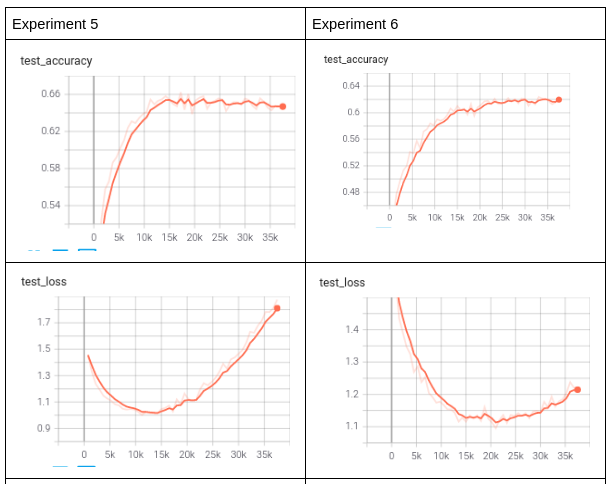

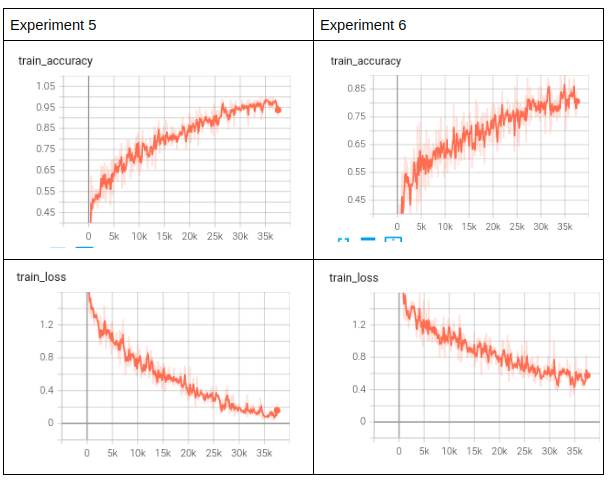

In terms of testing, the "best test accuracy" of experiment 5 is higher than of experiment 6, which is 66.233% compared to 62.492%, but for a more intuiitive comparision, let's look at the training graph of these 2 experiments as shown in above figures.
By looking at graph of test_loss, we can see that both experiments suffer overfitting, however the overfitting happens quite early for experiment 5 ,as we can see that the test_loss starts to increase from global_step 15k. While in experiment 6, the overfitting happens quite late, only after the global_step 25k. 
By looking at the graph for train_accuracy and train_loss, we can see that by the end of training process, the training in experiment 5 already converges , while the training in experiment 6 still not converges yet (the train_accuracy is below 90% and seems to increase if being trained for more epochs). 

Therefore it seems that in experiment 6, by using "botleneck" block type instead of "plain" block type, the model seems to converge more slowly.
In my opinion, this phenonmenon happens because using "bottleneck" block type instead of "plain" block type would increase the depth of our model, therefore the model would take more time to converge. 



**Finally**, let's compare experiment 5 and experiment 7:

These 2 experiments use the same setting, but the only difference is that experiment 5 sets num_resblocks = [1, 1, 1], while experiment 7 sets num_resblocks = [1, 2, 3]. 
Therefore we can compare these 2 experiments to see how num_resblocks affect the performance of model 

|                                   | Experiment 5       | Experiment 7       |
|-----------------------------------|--------------------|--------------------|
| Best test accuracy                | 66.233%            | 63.200%            |
| Test accuracy in ending 5 epochs  | 64.292% to 64.758% | 60.900% to 62.417% |
| Test loss in ending 5 epochs      | 1.2524 to 1.6835   | 1.1314 to 3.2502   |
| Train accuracy in ending 5 epochs | 90.625% to 96.875% | 95.312% to 98.438% |
| Train loss in ending 5 epochs     | 0.0801 to 0.2393   | 0.0610 to 0.1416   |

Looking at this table, we can see that the "best test accuracy" in experiment 5 is 66.233%, which is higher than of experiment 7 by 3%. Considering the test accuracy in ending 5 epochs, the statistics for  experiment 5 is also higher than of experiment 7 by about 2-4%. Lastly, the experiment 5 also archieves a lower range of test loss in ending 5 epochs compared to experiment 7. However, the statistics for training process shows a completely oposite trend: the training accuracy in ending 5 epochs from experiment 7 is about 2-5% higher than of experiment 5, and furthermore the range of train loss in ending 5 epochs of the experiment 7 is slightly smaller than of experiment 5. 

Therefore, in experiment 7, by increasing the num_resblocks from [1, 1, 1] to [1, 2, 3], it helps to boost the model's training accuracy, while decreasing model's testing accuracy.  

Thus, increasing the num_resblocks in experiment 7 seems to make the overfitting problem, which already exists in experiment 5, become even more worse. In my opinion, this happens because increasing the num_resblocks would increase the depth of the model and make it become more complex, therefore our model would be more affected by the overfitting problem. To remediate this problem, i think that in our model design, we should have more batchnorm layers and use other techniques such as dropout or scheduled learning rate instead of constant learning rate.

One final observation is that the model in experiment 7 is deeper than of experiment 5, but the training accuracy achieved by experiment 7 is still higher than of the one in experiment 5. Therefore , it indicates that our model in experiment 7 does not get the degradation problem (the problem of decreasing training accuracy when stacking more layers to model). I think this happens because our model use resnet blocks as the basic components, which help model to overcome the degradation problem. 